In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)



Mon Sep 13 03:24:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    61W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [3]:
!cat /proc/meminfo

MemTotal:       13302924 kB
MemFree:         7405836 kB
MemAvailable:   12433576 kB
Buffers:          153560 kB
Cached:          4985752 kB
SwapCached:            0 kB
Active:          1974000 kB
Inactive:        3622336 kB
Active(anon):     405792 kB
Inactive(anon):      464 kB
Active(file):    1568208 kB
Inactive(file):  3621872 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               840 kB
Writeback:             0 kB
AnonPages:        457008 kB
Mapped:           280156 kB
Shmem:              1188 kB
KReclaimable:     158272 kB
Slab:             211252 kB
SReclaimable:     158272 kB
SUnreclaim:        52980 kB
KernelStack:        4816 kB
PageTables:         6148 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    3172704 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       44788 kB
VmallocChunk:          0 kB
Percpu:          

# Preprocess

In [4]:
!pip install timeit
import timeit
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


ERROR: Could not find a version that satisfies the requirement timeit (from versions: none)
ERROR: No matching distribution found for timeit


# Date preparation

In [5]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
#display(train_data, noisy_train_data)

# Building the supporter autoencoder

## Part A

In [6]:
#encoder
encoder_input1 = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input1)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(x)
encoder1 = Model(encoder_input1, x, name="encoder_model1")
# Decoder
decoder_input1 = layers.Input(shape=(7, 7, 1))
x = layers.Conv2DTranspose(32, (3, 3), strides = 2, activation="relu", padding="same")(decoder_input1)
x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
decoder1 = Model(decoder_input1, x, name="decoder_model1")

ae_input1 = layers.Input(shape=(28, 28, 1), name="AE_input")
ae_encoder_output1 = encoder1(ae_input1)
ae_decoder_output1 = decoder1(ae_encoder_output1)

autoencoder1 = Model(ae_input1, ae_decoder_output1, name="AE1")
autoencoder1.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder1.summary()

Model: "AE1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AE_input (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_model1 (Functional)  (None, 7, 7, 1)           9857      
_________________________________________________________________
decoder_model1 (Functional)  (None, 28, 28, 1)         609       
Total params: 10,466
Trainable params: 10,466
Non-trainable params: 0
_________________________________________________________________


In [7]:
start = timeit.default_timer()

autoencoder1.fit(
    x=train_data,
    y=train_data,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

end = timeit.default_timer()

print("autoencoder1 training time:", end-start)

Epoch 1/25
469/469 [==============================] - 8s 13ms/step - loss: 0.2027 - val_loss: 0.1209
Epoch 2/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1135 - val_loss: 0.1081
Epoch 3/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1073 - val_loss: 0.1048
Epoch 4/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1049 - val_loss: 0.1028
Epoch 5/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1033 - val_loss: 0.1015
Epoch 6/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1021 - val_loss: 0.1004
Epoch 7/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1010 - val_loss: 0.0997
Epoch 8/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1001 - val_loss: 0.0986
Epoch 9/25
469/469 [==============================] - 6s 12ms/step - loss: 0.0994 - val_loss: 0.0981
Epoch 10/25
469/469 [==============================] - 6s 12ms/step - loss: 0.0988 - val_lo

In [8]:
start = timeit.default_timer()

autoencoder1.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

end = timeit.default_timer()

print("autoencoder1 training time:", end-start)

Epoch 1/25
469/469 [==============================] - 6s 13ms/step - loss: 0.1472 - val_loss: 0.1283
Epoch 2/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1276 - val_loss: 0.1251
Epoch 3/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1253 - val_loss: 0.1233
Epoch 4/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1238 - val_loss: 0.1220
Epoch 5/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1224 - val_loss: 0.1204
Epoch 6/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1211 - val_loss: 0.1197
Epoch 7/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1204 - val_loss: 0.1188
Epoch 8/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1198 - val_loss: 0.1183
Epoch 9/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1194 - val_loss: 0.1178
Epoch 10/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1187 - val_lo

## Part B

In [9]:
#encoder
encoder_input2 = layers.Input(shape=(28, 28, 1))
x = layers.MaxPooling2D((2, 2), padding="same")(encoder_input2)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(x)
encoder2 = Model(encoder_input2, x, name="encoder_model2")
encoder2.summary()

# Decoder
decoder_input2 = layers.Input(shape=(7, 7, 1))
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoder_input2)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
decoder2 = Model(decoder_input2, x, name="decoder_model2")
decoder2.summary()

ae_input2 = layers.Input(shape=(28,28,1), name="AE_input2")
ae_encoder_output2 = encoder2(ae_input2)
ae_decoder_output2 = decoder2(ae_encoder_output2)

autoencoder2 = Model(ae_input2, ae_decoder_output2, name="AE")
autoencoder2.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder2.summary()

Model: "encoder_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 1)           289       
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________
Model: "decoder_model2"
_________________________________________________________________
Layer (type)                 O

In [10]:
start = timeit.default_timer()

autoencoder2.fit(
    x=train_data,
    y=train_data,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

end = timeit.default_timer()

print("autoencoder2 training time:", end-start)

Epoch 1/25
469/469 [==============================] - 7s 13ms/step - loss: 0.2171 - val_loss: 0.1241
Epoch 2/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1195 - val_loss: 0.1147
Epoch 3/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1135 - val_loss: 0.1109
Epoch 4/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1106 - val_loss: 0.1085
Epoch 5/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1088 - val_loss: 0.1070
Epoch 6/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1076 - val_loss: 0.1060
Epoch 7/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1067 - val_loss: 0.1059
Epoch 8/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1060 - val_loss: 0.1047
Epoch 9/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1054 - val_loss: 0.1043
Epoch 10/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1050 - val_lo

In [11]:
start = timeit.default_timer()

autoencoder2.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

end = timeit.default_timer()

print("autoencoder2 training time:", end-start)

Epoch 1/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1637 - val_loss: 0.1505
Epoch 2/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1494 - val_loss: 0.1473
Epoch 3/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1476 - val_loss: 0.1461
Epoch 4/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1465 - val_loss: 0.1450
Epoch 5/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1458 - val_loss: 0.1446
Epoch 6/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1451 - val_loss: 0.1448
Epoch 7/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1447 - val_loss: 0.1433
Epoch 8/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1442 - val_loss: 0.1431
Epoch 9/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1438 - val_loss: 0.1426
Epoch 10/25
469/469 [==============================] - 6s 12ms/step - loss: 0.1434 - val_lo

# Combined 

In [29]:
start = timeit.default_timer()

Encoded = encoder1.predict(noisy_test_data)

end = timeit.default_timer()

print("encoding time:", end-start)

encoding time: 0.6921897990005164


In [30]:
print(np.amax(Encoded))

9.91922


Data scaling 

In [31]:
Encoded1 = encoder1.predict(noisy_test_data)
Encoded2 = encoder2.predict(noisy_test_data)
Maximum1 = np.amax(Encoded1)
Maximum2 = np.amax(Encoded2)

#sometime inverts

def normalize(x):
  factor = (Maximum1/Maximum2)
  x = x/factor
  x = x - x*0.1
  return x


# define vectorized sigmoid
normalize_v = np.vectorize(normalize)

In [32]:
print(Maximum2)

1.7567594


In [33]:
start = timeit.default_timer()

Encoded = normalize_v(Encoded)

end = timeit.default_timer()

print("translation time:", end-start)

translation time: 1.4105196880000221


In [34]:
start = timeit.default_timer()

Decoded = decoder2.predict(Encoded)

end = timeit.default_timer()

print("decoding time:", end-start)

decoding time: 0.5622448399999485


# finding loss

In [35]:
Loss = []

for i in range(10000):
  loss = np.square(np.subtract(Decoded[i], test_data[i])).mean()
  Loss.append(loss)

In [36]:
Average = sum(Loss) / len(Loss)

In [37]:
print(Average)

0.03289346054922789


In [38]:
Loss = []
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

for i in range(10000):
  loss = bce(Decoded[i], test_data[i])
  Loss.append(loss)

In [39]:
Average = sum(Loss) / len(Loss)

In [40]:
print(Average)

tf.Tensor(0.6723735, shape=(), dtype=float32)


In [41]:
Image = 111

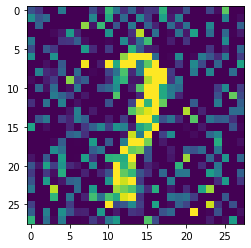

In [42]:
plt.imshow(noisy_test_data[Image].reshape((28,28)))

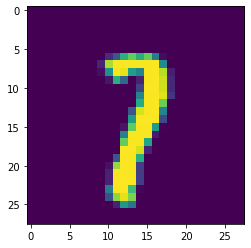

In [43]:
plt.imshow(test_data[Image].reshape((28,28)))

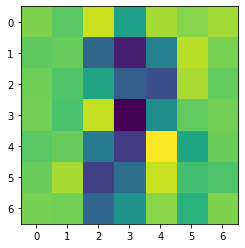

In [44]:
plt.imshow(Encoded[Image].reshape((7,7)))

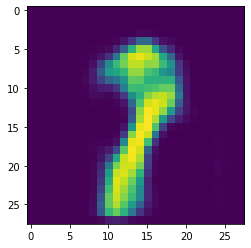

In [45]:
plt.imshow(Decoded[Image].reshape((28,28)))